#Machine Learning Final Project

The goal of this notebook is to try to build a model to discriminate AI generated texts and human generated ones


In this notebook we will:
1. Load libraries and configuration
2. Load and explore the data







#📓 | Preparation

## Install and import libraries

In [32]:
!pip install seaborn
!pip install tensorflow==2.12.0
!pip install tensorflow-text==2.12.0
!pip install keras_core==0.1.7
!pip install  keras_nlp==0.6.1
!pip install nltk
!pip install textstat
!pip install ipywidgets

In [33]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras_core as keras
import keras_nlp

import nltk
from nltk.util import ngrams
import textstat
from collections import Counter
import tqdm

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

nltk.download('punkt')
nltk.download('stopwords')
tqdm.tqdm.pandas()

sns.set_context('notebook')
sns.set_theme()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("KerasNLP version:", keras_nlp.__version__)
print("NLTK version:", nltk.__version__)

TensorFlow version: 2.12.0
Keras version: 0.1.7
KerasNLP version: 0.6.1
NLTK version: 3.8.1


## Config

In [35]:
class  Config:
    PROJECT_ROOT = "/content/project_data/"
    BERT_SAMPLE_SIZE = 1000
    LR_SAMPLE_SIZE = 25000
    TEST_SIZE = 0.33

    # For reproducatbility
    RANDOM_STATE = 42

    # BERT Hyperparameters
    ADAM_PARAMETER_VALUE = 5e-4
    BERT_EPOCHS = 1
    BERT_BATCH_SIZE = 64


##Hardware
Automatically detects hardware (TPU, GPU or CPU...)

Code from https://www.kaggle.com/code/awsaf49/detect-fake-text-kerasnlp-tf-torch-jax-train/notebook#%F0%9F%92%BE-%7C-Hardware

In [ ]:
try:
    # detect and init the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

    # instantiate a distribution strategy
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print(f'> Running on TPU', tpu.master(), end=' | ')
    print('Num of TPUs: ', strategy.num_replicas_in_sync)
    device='TPU'
except:
    # If TPU is not available, detect GPUs
    gpus = tf.config.list_logical_devices('GPU')
    ngpu = len(gpus)
        # Check number of GPUs
    if ngpu:
        # Set GPU strategy
        strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
        # Print GPU details
        print("> Running on GPU", end=' | ')
        print("Num of GPUs: ", ngpu)
        device='GPU'
    else:
        # If no GPUs are available, use CPU
        print("> Running on CPU")
        strategy = tf.distribute.get_strategy()
        device='CPU'

> Running on CPU


#🔎 | Load and Explore Data


From the official competition (https://www.kaggle.com/competitions/llm-detect-ai-generated-text) :
- train_essays.csv

Additionnal dataset with more AI generated text (@drcat):
- train_drcat_04.csv

Testing data :
- test_essays.csv

In [ ]:
# Execute only if data is in your google drive, in a folder 'project_data' at the root

from google.colab import drive
drive.mount('/content/drive')

Config.PROJECT_ROOT = '/content/drive/MyDrive/project_data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_essays = pd.read_csv(f"{Config.PROJECT_ROOT}/train_essays.csv")
train_essays.Name = "Train essays"


train_drcat = pd.read_csv(f"{Config.PROJECT_ROOT}/train_drcat_04.csv")
train_drcat.rename(columns = {"label" : "generated"}, inplace=True)
train_drcat.Name = "External train essays"

test_essays = pd.read_csv(f"{Config.PROJECT_ROOT}/test_essays.csv")
test_essays.Name = "Test essays"

Let's load and explore data in order to undestand how it is structured, the amount we got, etc.

We can look at :
- The amount of data (number of lines)
- The distribution of AI generated and student generated essays
- The length of generated essays
- The first rows of each frame to see how the data look
...

##Train essays



In [ ]:
train_essays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB


In [ ]:
print("Sample :")
display(train_essays.head())

Sample :


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


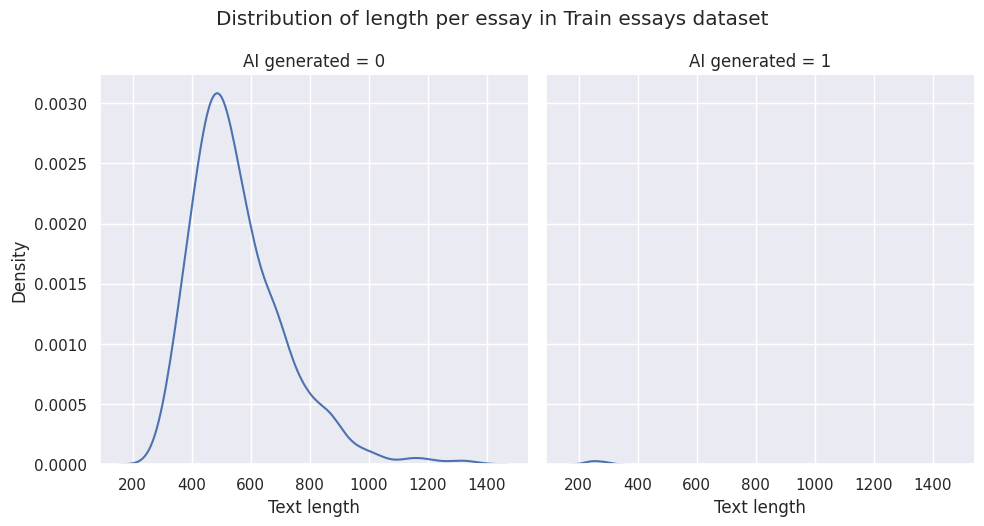

In [ ]:
train_essays["text_length"] = train_essays["text"].apply(lambda x: len(x.split()))
plot = sns.displot(data=train_essays, x="text_length", kind='kde', col='generated')
plot.fig.suptitle(f"Distribution of length per essay in {train_essays.Name} dataset", y=1.05)
plot.set_titles("AI generated = {col_name}")
plot.set_axis_labels("Text length", "Density")

Text(0, 0.5, 'Count')

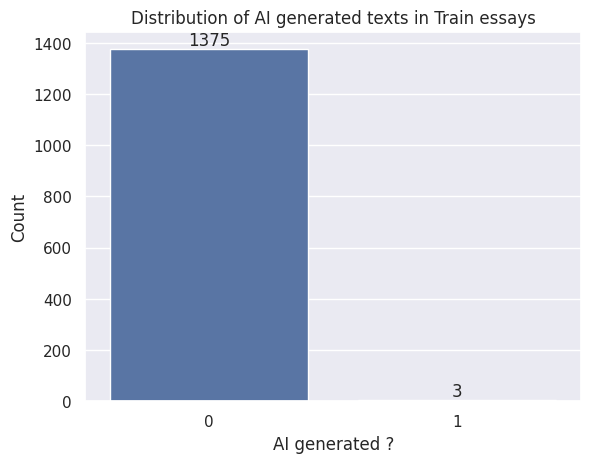

In [ ]:
ax = sns.countplot(train_essays, x='generated')
ax.bar_label(ax.containers[0])
plt.title(f"Distribution of AI generated texts in {train_essays.Name}")
plt.xlabel("AI generated ?")
plt.ylabel("Count")

##External train essays

In [ ]:
train_drcat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44206 entries, 0 to 44205
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   44206 non-null  object
 1   text       44206 non-null  object
 2   generated  44206 non-null  int64 
 3   source     44206 non-null  object
 4   prompt     12911 non-null  object
 5   fold       44206 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


In [ ]:
display(train_drcat.head())

,essay_id,text,generated,source,prompt,fold
0,E897534557AF,"In recent years, technology has had a profoun...",1,mistral7binstruct_v2,\nTask: Write an essay discussing the positive...,1
1,DFBA34FFE11D,Should students participate in an extracurricu...,0,persuade_corpus,NaN,2
2,af37ecf5,The electoral college is a symbol of mockery a...,0,train_essays,NaN,5
3,5EC2696BAD78,This is why I think the principle should allow...,0,persuade_corpus,NaN,8
4,llama_70b_v1843,I strongly believe that meditation and mindful...,1,llama_70b_v1,Some schools have implemented meditation and m...,0


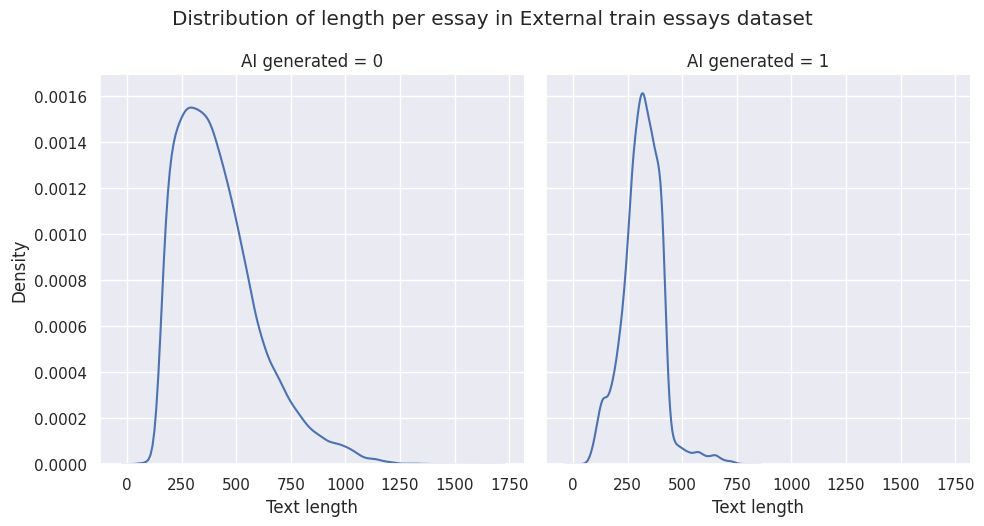

In [ ]:
train_drcat["text_length"] = train_drcat["text"].apply(lambda x: len(x.split()))
plot = sns.displot(data=train_drcat, x="text_length", kind='kde', col='generated')
plot.fig.suptitle(f"Distribution of length per essay in {train_drcat.Name} dataset", y=1.05)
plot.set_titles("AI generated = {col_name}")
plot.set_axis_labels("Text length", "Density")

Text(0, 0.5, 'Count')

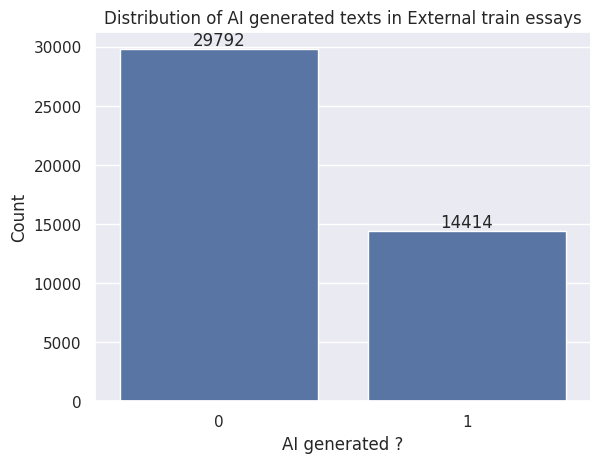

In [ ]:
ax = sns.countplot(train_drcat, x='generated')
ax.bar_label(ax.containers[0])
plt.title(f"Distribution of AI generated texts in {train_drcat.Name}")
plt.xlabel("AI generated ?")
plt.ylabel("Count")

##Test essays

In [ ]:
test_essays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         3 non-null      object
 1   prompt_id  3 non-null      int64 
 2   text       3 non-null      object
dtypes: int64(1), object(2)
memory usage: 200.0+ bytes


In [ ]:
display(test_essays.head())

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [ ]:
print(test_essays["text"].apply(lambda x: len(x.split())))

0    3
1    3
2    3
Name: text, dtype: int64


##Data exploration conclusions
* Train essays have a very small number of IA generated essays. We will complete it with the External train essays which has a lot more
* IA generated essays seems slightly shorter and less spread out in number of words
* The test dataset contains only three very small essays which don't seem to answer correctly to the prompts

## Merge data
1. Merge additional data (train_drcat_04) and train essays. Only keep texts and label ('generated')
2. To make sure that we have the same number of AI generated and human written texts. We have to split according to 'generated' column
3. Merge data again on a sample with as many AI generated and human written texts.

In [ ]:
merge_dataset = pd.concat([train_essays[["text", "generated"]], train_drcat[["text", "generated"]]])
merge_ai = merge_dataset[merge_dataset["generated"] == 1]
merge_human = merge_dataset[merge_dataset["generated"] == 0]

bert_text_dataset = pd.concat([merge_ai.sample(Config.BERT_SAMPLE_SIZE // 2)[["text", "generated"]], merge_human.sample(Config.BERT_SAMPLE_SIZE // 2)[["text", "generated"]]])
bert_text_dataset.Name = "Final text dataset for BERT"

LR_text_dataset =  pd.concat([merge_ai.sample(Config.LR_SAMPLE_SIZE // 2)[["text", "generated"]], merge_human.sample(Config.LR_SAMPLE_SIZE // 2)[["text", "generated"]]])
LR_text_dataset.Name = "Final text dataset for Logistic Regression"

bert_text_dataset.info()
LR_text_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 18288 to 33901
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1000 non-null   object
 1   generated  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 11550 to 37082
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       25000 non-null  object
 1   generated  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 585.9+ KB


#⛏ | Feature Extraction

We can extract features using stylometrics caracteristics such as:
- Flesh Reading Reading ease score
- Variance of the length of sentences

These features are additionnal data available in order to train our model.

In [ ]:
def get_sentences_length_var(text):
    """Sentence length variance (in words count)"""
    sentences = nltk.tokenize.sent_tokenize(text)
    length_tab = [len(nltk.tokenize.word_tokenize(sent)) for sent in sentences]
    return np.var(length_tab)

bert_text_dataset['readability_score'] = bert_text_dataset['text'].progress_apply(textstat.flesch_reading_ease)
bert_text_dataset['sentence_length_variance'] = bert_text_dataset['text'].progress_apply(get_sentences_length_var)

100%|██████████| 3000/3000 [00:08<00:00, 349.92it/s]


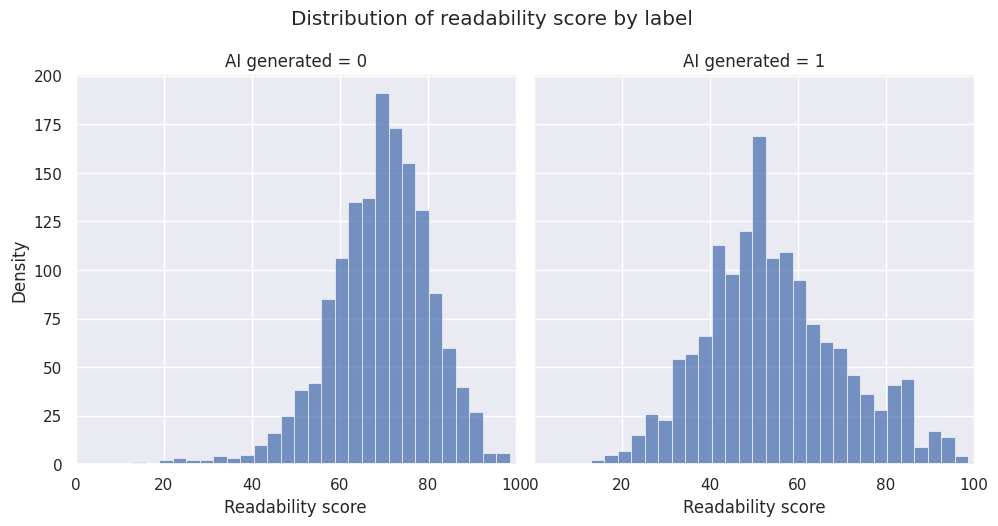

In [ ]:
readability_plot = sns.displot(data=bert_text_dataset, x="readability_score", col='generated')
readability_plot.set(xlim=(0, 100))
readability_plot.fig.suptitle(f"Distribution of readability score by label", y=1.05)
readability_plot.set_titles("AI generated = {col_name}")
readability_plot.set_axis_labels("Readability score", "Density")

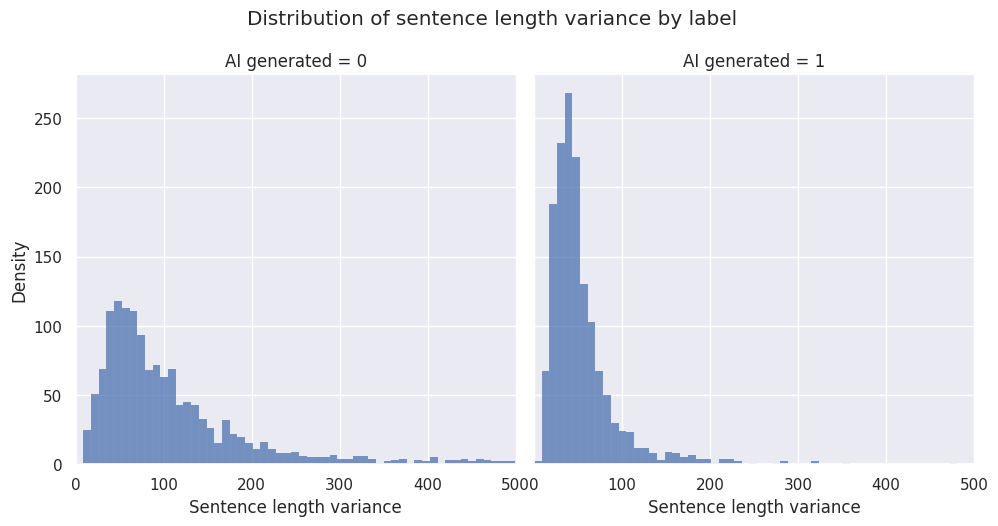

In [ ]:
readability_plot = sns.displot(data=bert_text_dataset, x="sentence_length_variance", col='generated')
readability_plot.set(xlim=(0, 500))
readability_plot.fig.suptitle(f"Distribution of sentence length variance by label", y=1.05)
readability_plot.set_titles("AI generated = {col_name}")
readability_plot.set_axis_labels("Sentence length variance", "Density")

▶ We observe that both calculated features are more spread out for AI generated texts than for human written ones. Moreover, readability score is lower for AI.

It would be interesting to use these new, extracted features to train our model, as it seems that it could carry useful data.

Unfortunately, as we did not find how to do so (with vectorization), these features remain unused.

It reveals nonetheless interesting insights on AI generated texts and human written ones.

# Tests utils
Let's create some utils functions for scoring and testing performances of our future models:
* f1 score
* accuracy
* precision
* recall
* confusion matrix

**Note** : AUC would have been very intersting but we unfortunately did not have the time to implement this evaluation.

In [ ]:
def f1_score(tn, fp, fn, tp):
    return tp / (tp+((fn+fp)/2))

def accuracy(tn, fp, fn, tp):
    return (tp + tn) / (tp + tn + fp + fn)

def precision(tn, fp, fn, tp):
    return tp / (tp + fp)

def recall(tn, fp, fn, tp):
    return tp / (tp + fn)

def displayConfusionMatrix(y_true, y_pred, title, color):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=["Not AI Generated","AI Generated"],
        cmap=color
    )
    disp.ax_.set_title(title)


    return confusion_matrix(y_true, y_pred).ravel()

def compute_scores(results):
  return [f1_score(*results), accuracy(*results), precision(*results), recall(*results)]

def display_scores(scores_dict: dict):
    scores_df = pd.DataFrame({
        'Metric': ['F1-Score', 'Accuracy', 'Precision', 'Recall']
    })

    for k, v in scores_dict.items():
        scores_df[k] = v

    display(scores_df)


# Models construction and training

In this part we will create and train 2 models to classify our texts:

1. One based on **DistillBert**. We use a model based on BERT for the following reasons :
  * It supports vectorization AND classification
  * It capture the meaning of the words depending of the context
  * This is the most seen implementation in the examples we read, thus easier to implement for us
2. One using TF-IDF to vectorize then a **logistic regression** to classify, for the following reason:
  * We wanted to train another model, without Bert, so we could experiment for example with TF-IDF for vectorization
  * Logistic regression is quite simple and does not have too many hyperparameters, thus making it a better choice for beginner (even if it may be less efficient or powerful)
  * The training of the model is very fast (time has been the greatest downside of our first model, with DistillBert)

Each one will be trained of a different amount of data because of their different performances.

## 1 - **BERT**

We chose Bert beacause it understands words in context, works well on different language tasks, and has community support (We found that it has been used in several Kaggle competitions)

### ✂ | Data split
Before getting started with BERT, we will split our text_dataset into training set and testing set.

In [ ]:
# Split the dataset into train and test sets

x_train, x_test, y_train, y_test = train_test_split(bert_text_dataset["text"],
                                                    bert_text_dataset["generated"],
                                                    test_size=Config.TEST_SIZE,
                                                    random_state=Config.RANDOM_STATE)
test_sample_size = len(y_test)

### Model definition
Vectorisation tends to convert input data from its raw format (i.e. text ) into vectors of real numbers which is the format that ML models support.
Many techniques exist like **Bag of Words**, **TF-IDF** and **Bert** on which we are focusing.

**Bert** is a language model designed for representing natural language texts that has the particularity to represent a word based on its meaning within the context of the text by considering both the preceding and following words (bidirectional).

Besides, it is pretrained on a large corpus and can be fine tuned to adapt to our specific needs.

Here, the pretrained model we use is **DistilBert**, because it has 40% less parameters than google-bert/bert-base-uncased, runs 60% faster while preserving over 95% of BERT's performances.

Another interesting fact is that pretrained BERT can be used to vectorize the text (preprocessing), and we can use the fine tuned one to classify texts

In [ ]:
class DistillBertModel:

    SEQ_LENGTH = 512    # We choose 512 because it's the limit of DistilBert

    def __init__(self):
        self.preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
            "distil_bert_base_en_uncased",
            sequence_length=DistillBertModel.SEQ_LENGTH,
        )

        # Pretrained classifier.
        self.classifier = keras_nlp.models.DistilBertClassifier.from_preset(
            "distil_bert_base_en_uncased",
            num_classes=2,
            activation=None, preprocessor=self.preprocessor,
        )

        self.training_time = 0
        self.results = []
        self.scores = []

    def compile(self):
        self.classifier.compile(
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.Adam(Config.ADAM_PARAMETER_VALUE),
            metrics=[
                keras.metrics.SparseCategoricalAccuracy()
            ]
        )
        self.classifier.backbone.trainable = False

    def train(self, x_train, y_train, x_test, y_test):
        start = time.time()
        self.classifier.fit(x=x_train,
            y=y_train,
            validation_data=(x_test, y_test),
            epochs=Config.BERT_EPOCHS,
            batch_size=Config.BERT_BATCH_SIZE
        )
        end = time.time()
        self.training_time = end - start

    def predict(self, texts):
        return np.argmax(self.classifier.predict(texts), axis=1)


### Construction

In [ ]:
bert_model = DistillBertModel()
bert_model.compile()
bert_model.classifier.summary()

Preprocessor: "distil_bert_preprocessor_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer_4 (DistilBertTokenizer)      │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ distil_bert_backbone_4        │ (None, None, 768)         │  66,362,880 │ padding_mask[0][0],            │
│ (DistilBertBackbone)          │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ get_item_4 (GetItem)          │ (None, 768)               │           0 │ distil_bert_backbone_4[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │     590,592 │ get_item_4[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │           0 │ pooled_dense[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │       1,538 │ classifier_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 592,130 (2.26 MB)

 Non-trainable params: 66,362,880 (253.15 MB)

### Training



In [ ]:
bert_model.train(x_train, y_train, x_test, y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 983s 89s/step - loss: 0.6274 - sparse_categorical_accuracy: 0.5945 - val_loss: 0.3954 - val_sparse_categorical_accuracy: 0.8606


### Bert Tests

11/11 ━━━━━━━━━━━━━━━━━━━━ 255s 23s/step


,Metric,DistillBERT
0,F1-Score,0.864706
1,Accuracy,0.860606
2,Precision,0.840000
3,Recall,0.890909


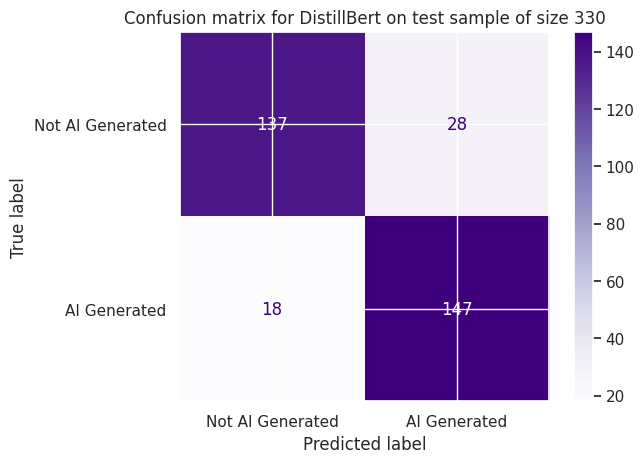

In [ ]:
y_pred = bert_model.predict(x_test)
bert_model.results = displayConfusionMatrix(y_test, y_pred, f"Confusion matrix for DistillBert on test sample of size {test_sample_size}", plt.cm.Purples)
bert_model.scores = compute_scores(bert_model.results)
display_scores({"DistillBERT": bert_model.scores})

### Save
Save for future use.

In [ ]:
import pickle
# save model
pickle.dump(bert_model, open(f"{Config.PROJECT_ROOT}/BERT_model.pickle", "wb"))

## 2 - Logistic Regression :

We chose  Logistic regression because it is easy to implement is relatively straightforward to implement and understand compared to some more advanced models.

### ✂ | Data split


In [ ]:
# Split the dataset into train and test sets

x_train, x_test, y_train, y_test = train_test_split(LR_text_dataset["text"],
                                                    LR_text_dataset["generated"],
                                                    test_size=Config.TEST_SIZE,
                                                    random_state=Config.RANDOM_STATE)
test_sample_size = len(y_test)

### Vectorization with TF-IDF

In this part, we will use **TF-IDF** (Term Frequency-Inverse Document Frequency ) for vectorisation. It's a numerical statistic that reflects the importance of a word in corpus. This is how it works : Initially, two metrics, **TF (term frequency)** and **IDF (invert document frequency)** are computed for each term in a document. Subsequently, a score is assigned to each term, calculated as the product of its TF and IDF. Once TF-IDF scores are determined for all terms across the entire corpus, the outcome is represented as a matrix used as the input for our model.

### Model definition

In [ ]:
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

class LRModel:

    def __init__(self):
        # Create a TF-IDF vectorizer with default settings
        self.vectorizer = TfidfVectorizer()

        # Initialize and fit the Logistic Regression model
        self.classifier = LogisticRegression()

        self.training_time = 0
        self.scores = []
        self.results = []

    def clean_data(self, text):
        # suppression of stopwords, stemming
        stop_words = set(stopwords.words('english'))
        ps = PorterStemmer()

        # Tokenization
        words = word_tokenize(text)

        # Remove stopwords and apply stemming
        cleaned_words = [ps.stem(word.lower()) for word in words if word.isalpha() and word.lower() not in stop_words]

        # Join cleaned words back into a sentence
        cleaned_text = ' '.join(cleaned_words)

        return cleaned_text

    def train(self, x_train, y_train):
        start = time.time()

        # clean
        x_train_cleaned = [self.clean_data(text) for text in x_train]

        x_vectorized =  self.vectorizer.fit_transform(x_train_cleaned)

        self.classifier.fit(
            x_vectorized,
            y=y_train
        )

        end = time.time()
        self.training_time = end - start

    def predict(self, texts):
        # clean
        texts_cleaned = [self.clean_data(text) for text in texts]

        vectorized = self.vectorizer.transform(texts_cleaned)
        return self.classifier.predict(vectorized)


### Construction

In [ ]:
lr_model = LRModel()

### Training

Now, let's use **Logistic Regression** to train our dataset

In [ ]:
lr_model.train(x_train, y_train)

### Tests

,Metric,Logistic Regression
0,F1-Score,0.975770
1,Accuracy,0.975879
2,Precision,0.978271
3,Recall,0.973282


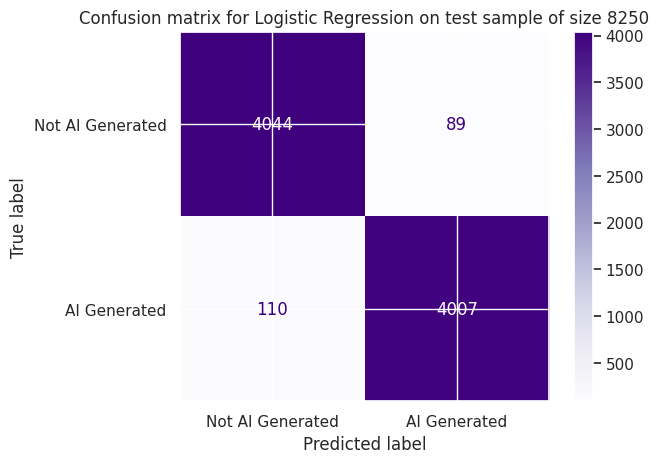

In [ ]:
y_pred = lr_model.predict(x_test)
lr_model.results = displayConfusionMatrix(y_test, y_pred, f"Confusion matrix for Logistic Regression on test sample of size {test_sample_size}", plt.cm.Purples)
lr_model.scores = compute_scores(lr_model.results)
display_scores({"Logistic Regression": lr_model.scores})

### Save

In [ ]:
import pickle
# save model
pickle.dump(lr_model, open(f"{Config.PROJECT_ROOT}/LR_model.pickle", "wb"))

# Comparison of both models

In [ ]:
import pickle
# Reload models if necessary
bert_model = pickle.load(open(f"{Config.PROJECT_ROOT}/BERT_model.pickle", "rb"))
lr_model = pickle.load(open(f"{Config.PROJECT_ROOT}/LR_model.pickle", "rb"))

## 1.Confusion matrix comparison

In [ ]:
def to_percentage(df):
    return np.round(df / np.sum(df) * 100, 2)

results_df = pd.DataFrame({
    'Metric (%)': ['True Negative', 'False Positive', 'False Negative', 'True Positive'],
    'BERT': to_percentage(bert_model.results),
    'Logistic Regression': to_percentage(lr_model.results)
})
# display the comparative table
display(results_df)

,Metric (%),BERT,Logistic Regression
0,True Negative,41.52,49.02
1,False Positive,8.48,1.08
2,False Negative,5.45,1.33
3,True Positive,44.55,48.57


## 2. Scores comparison

In [ ]:
display_scores({"BERT": bert_model.scores, "Logistic Regression": lr_model.scores})

,Metric,BERT,Logistic Regression
0,F1-Score,0.864706,0.975770
1,Accuracy,0.860606,0.975879
2,Precision,0.840000,0.978271
3,Recall,0.890909,0.973282


## 3.Training time comparison

In [ ]:
bert_fit_execution_time = 0
training_time_df = pd.DataFrame({
    'Metric': ['Training time (s)'],
    'BERT': round(bert_model.training_time, 2),
    'Logistic Regression': round(lr_model.training_time, 2)
  })

display(training_time_df)

,Metric,BERT,Logistic Regression
0,Training time (s),984.54,121.72


**⚡** So to conclude this section of comparison between the two models, we were able to notice that the LR model  has better scores than Bert model and presents higher rates of true positives (texts generated by IA and flagged IA) and true negatives (texts written by human and flagged human). Besides, training execution time is much shorter for LR than Bert (~2min to train on 25 000 texts while bert is very-time consuming with ~16.5min to train on 1000 texts). **This observation surprised us a lot because we thought that Bert with its Transformers was more powerful. However, in our case, the simplistic model of LR has outperformed it on all levels**.

However, we have to consider the risk of an overfit for logistic regression.

# User test
Now that both of our models have been trained and their performances evaluated, we encourage you to test and compare them. To do so, input any text (whether generated by AI or written by a human) in the provided box, and observe the predictions of our models : it's your turn to play !

In [36]:
import pickle
# Reload models if necessary
bert_model = pickle.load(open(f"{Config.PROJECT_ROOT}/BERT_model.pickle", "rb"))
lr_model = pickle.load(open(f"{Config.PROJECT_ROOT}/LR_model.pickle", "rb"))

FileNotFoundError: [Errno 2] No such file or directory: '/content/project_data//BERT_model.pickle'

In [ ]:
from ipywidgets import widgets

def format_result(result):
    return "AI generated" if result else "Human written"

def try_model():
    print("Welcome to the Model Comparison Interface")
    print("Enter text below and observe predictions from BERT and Logistic Regression models.")

    predict_button = widgets.Button(description="Predict", button_style='success')
    try_model.output_variable = (widgets.Text())
    display(try_model.output_variable)
    display(predict_button)

    def on_click(b):
        bert_res = bert_model.predict([try_model.output_variable.value])
        lr_res = lr_model.predict([try_model.output_variable.value])

        print("Text you entered:\t" + try_model.output_variable.value, ("-" * 50), sep='\n')
        print(f"{'BERT result':30} : {format_result(bert_res)}")
        print(f"{'Logistic regression result':30} : {format_result(lr_res)}")
        print("=" * 50)

    predict_button.on_click(on_click)

try_model()

Welcome to the Model Comparison Interface
Enter text below and observe predictions from BERT and Logistic Regression models.


Text(value='')

Button(button_style='success', description='Predict', style=ButtonStyle())

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Text you entered:	Hello there, I am human.
--------------------------------------------------
BERT result                    : Human written
Logistic regression result     : Human written
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Text you entered:	Trains are primarily designed for transportation of goods and people over long distances efficiently. They offer several advantages:  Mass Transportation: Trains can carry large numbers of passengers or freight in a single journey, making them efficient for mass transportation.  Efficiency: Trains are often more fuel-efficient and environmentally friendly compared to individual vehicles, especially when transporting large volumes of goods or passengers over long distances.  Cargo Transportation: Trains are used extensively for transporting goods such as raw materials, manufactured products, and bulk commodities like coal, oil, and grain.  Passenger Transportation: Trains provide a convenient and relatively fast m

Example of tests and results :

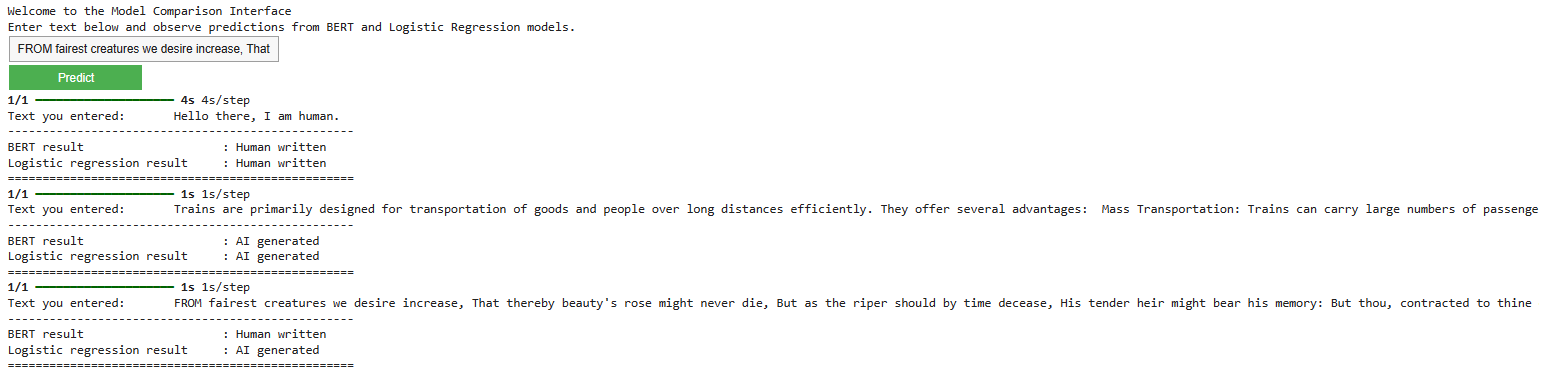
1. Human generated (by the user)
2. Generated by ChatGPT (What trains are made for ?)
3. William Shakespear - Sonnet I

→ As you can see, both models perform well with texts they have never seen before. These predictions seem pretty accurate, eventhough both models don't output the same result for the third text (DistillBert was right).

# Ameliorations

- Use the extracted features (see [#Feature extraction](https://colab.research.google.com/drive/1LyoHyK9A6IRD9auRLGBCyZJMK6B8lhXr?authuser=1#scrollTo=_Feature_Extraction))
- Implement dimensionnality reduction → To reduce overfit and simplify the model
- Train BERT with more data
- Change hyperparameters (and maybe do a GridSearchCV) → we did not have the time to try it.

# References

[Kaggle competition - llm detect ai generated text](https://www.kaggle.com/competitions/llm-detect-ai-generated-text)

[KerasNLP starter notebook - LLM detect AI generate](https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-llm-detect-ai-generate/notebook)

[Notebook - Detect fake text - keras nlp tf torch jax train](https://www.kaggle.com/code/awsaf49/detect-fake-text-kerasnlp-tf-torch-jax-train)

[Notebook - Deep Learning for nlp - Zero to transformers bert](https://www.kaggle.com/code/tanulsingh077/deep-learning-for-nlp-zero-to-transformers-bert)

[Save and load scikit learn models](https://mljar.com/blog/save-load-scikit-learn-model/)

[Widgets in Google collab](https://forums.fast.ai/t/workaround-to-using-widgets-in-colab/66312)

...And of course official libraries documentation